In [2]:
from __future__ import annotations

import fridom.shallowwater as sw
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import gridspec, ticker

# ----------------------------------------------------------------
#  Constants
# ----------------------------------------------------------------

RESOLUTION_FACTOR = 9
ROSSBY_NUMBER = 0.1  # advection scale

# ================================================================
#  Setup
# ================================================================

lx = ly = 2 * np.pi
nx = ny = 2**RESOLUTION_FACTOR - 1

# construct grid and modelsettings
grid = sw.grid.cartesian.Grid(N=(nx, ny), L=(lx, ly), periodic_bounds=(True, True))
mset = sw.ModelSettings(grid, f0=1.0, beta=0.0, csqr=1.0, Ro=ROSSBY_NUMBER).setup()

z_evo = sw.State.from_netcdf(mset, "../data/examples/shallow_water_random_bound/z_evo.nc")
z_evo_bal = sw.State.from_netcdf(mset, "../data/examples/shallow_water_random_bound/z_evo_bal.nc")
z_evo_res = z_evo - z_evo_bal

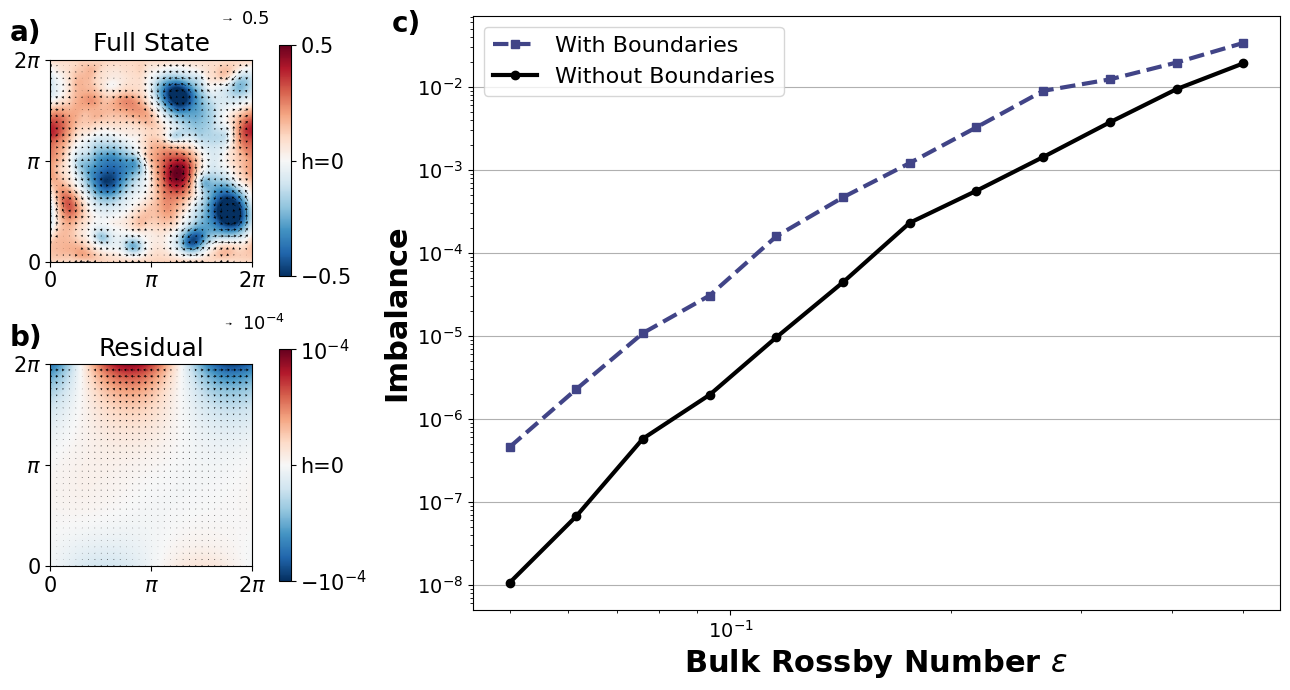

: 

In [ ]:
fig = plt.figure(figsize=(13, 7), tight_layout=True)
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 3], height_ratios=[1, 1])
axs = [fig.add_subplot(gs[j, 0]) for j in range(2)]
ax = fig.add_subplot(gs[:, 1])


def create_subplot(ax: plt.Axes,  #noqa: PLR0913
                   z: sw.State,
                   label: str,
                   title: str,
                   vmax: float,
                   max_vel: float,
                   cmap: str) -> None:
    """Create a subplot for the given state."""
    # create a plot of the pressure field
    im = z.p.xr.plot(ax=ax, cmap=cmap, vmin=-vmax, vmax=vmax, add_colorbar=False)

    # create a quiver plot of the velocity field
    skip = 2**(RESOLUTION_FACTOR - 5)
    m_vel = (z.u**2 + z.v**2).max().arr.item()**0.5
    q = (z.velocity/m_vel).xrs[::skip, ::skip].plot.quiver(
        "x", "y", "u", "v",
        ax=ax, color="black", scale=30 * max_vel / m_vel, headwidth=6, add_guide=False)

    # add a quiver key with white background
    lb = f"{vmax:.2g}" if vmax > 1e-4 else r"$10^{-4}$"
    qk = ax.quiverkey(q, X=0.9, Y=1.2, U=1, label=lb, labelpos="E",
                    fontproperties={"size": 13})

    # create a colorbar
    formatter = ticker.ScalarFormatter(useMathText=False)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    if vmax > 1e-4:
        labels = [f"${-vmax:.2g}$", "h=0", f"${vmax:.2g}$"]
    else:
        labels = ["$-10^{-4}$", "h=0", "$10^{-4}$"]
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.1, shrink=0.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.set_ticks([-vmax, 0, vmax], labels=labels)
    cbar.ax.tick_params(labelsize=15)
    # move the colorbar label to the left
    # cbar.set_label("Pressure", fontsize=15, labelpad=-23)


    ax.set_aspect("equal")
    ax.set_title(title, fontsize=18)
    ax.set_xticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"], fontsize=15)
    ax.set_yticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"], fontsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.text(-0.2, 1.2, label, fontsize=20, fontweight="bold",
            transform=ax.transAxes, va="top", ha="left")


create_subplot(axs[0], z_evo, "a)", "Full State", 0.5, 1.0, "RdBu_r")
create_subplot(axs[1], z_evo_res, "b)", "Residual", 1e-4, 1e-4, "RdBu_r")

ds = xr.load_dataset("../data/rossby_number_sw.nc", decode_timedelta=False)
dsb = xr.load_dataset("../data/rossby_number_bound_sw.nc", decode_timedelta=False)

colors = plt.cm.viridis_r(np.linspace(0.2, 0.8, len(ds.number_chunks)))[::-1]
labels = iter(["a)", "b)", "c)", "d)", "e)", "f)"])



# With boundaries
dsb.imbalance.plot(
            ax=ax, marker="s", color=colors[0], lw=3, linestyle="--",
            label="With Boundaries",
        )

# No boundaries
ds.sel({"initial_condition": "random",
        "number_chunks":1,
        "balancing_method": "ob"}).imbalance.plot(
            ax=ax, marker="o", color="black", lw=3, label="Without Boundaries",
        )

ax.legend(fontsize=16, frameon=True)
ax.tick_params(labelsize=14)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(axis="y")
ax.set_xlabel(r"Bulk Rossby Number $\epsilon$", fontsize=22, fontweight="bold")
ax.set_ylabel("Imbalance", fontsize=22, fontweight="bold")
ax.set_title("")
ax.text(-0.10, 1.01, "c)", fontsize=20, fontweight="bold",
        transform=ax.transAxes, va="top", ha="left")

plt.savefig("../figures/lateral_boundaries.png", dpi=200)